# Megaline project

## description

The telecom operator Megaline offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.
We are going to carry out a preliminary analysis of the plans based on a relatively small client selection. We'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Our job is to analyze clients' behavior and determine which prepaid plan brings in more revenue.
Description of the plans
Note: Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

Surf
- Monthly charge: 20 dollars
- 500 monthly minutes, 50 texts, and 15 GB of data
- After exceeding the package limits:
- 1 minute: 3 cents
- 1 text message: 3 cents
- 1 GB of data: 10 dollars

Ultimate
- Monthly charge: 70 dollars
- 3000 monthly minutes, 1000 text messages, and 30 GB of data
- After exceeding the package limits:
- 1 minute: 1 cent
- 1 text message: 1 cent
- 1 GB of data: 7 dollars

[Step 1:Open the data file and Explore initial data](#Open-the-data-files)

[Step 2:Data preprocessing](#Step-2.-Prepare-the-data)

- [Data mergeing](#Data-mergeing)

- [Enrich data](#Adding-monthly-revenue)

[Step 3:Study core parameters](#Step-3.-Analyze-the-data)

- [Call minutes](#Call-minutes)

- [Internet data](#Internet-data)

- [Messages](#Messages)

- [Monthly revenue](#Monthly-revenue)


[Step 4: Hypotheses testing](#Step-4:-Test-the-hypotheses)

- [Hypotheses 1](#First-hypotheses)

- [Hypotheses 2](#Second-hypotheses)

[Final Conclussions](#Conclusions)

In [1]:
pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings

warnings.filterwarnings("ignore")

## Open the data files

In [4]:
try:
    
    call_data = pd.read_csv('D:\Tammy\Downloads\SDA data/megaline_calls.csv') 

    web_data = pd.read_csv('D:\Tammy\Downloads\SDA data/megaline_internet.csv')

    sms_data = pd.read_csv('D:\Tammy\Downloads\SDA data/megaline_messages.csv')

    plan_data = pd.read_csv('D:\Tammy\Downloads\SDA data/megaline_plans.csv')

    user_data = pd.read_csv('D:\Tammy\Downloads\SDA data/megaline_users.csv') 
    
except:
    
    call_data = pd.read_csv('/datasets/megaline_calls.csv') 

    web_data = pd.read_csv('/datasets/megaline_internet.csv')

    sms_data = pd.read_csv('/datasets/megaline_messages.csv')

    plan_data = pd.read_csv('/datasets/megaline_plans.csv')

    user_data = pd.read_csv('/datasets/megaline_users.csv') 

    

In [7]:
def first_look(parameter):
    print('The info of')
    (parameter).info()
    print('No. of duplicates {}'.format((parameter).duplicated().sum()))
    print('No. of missing values {}'.format((parameter).isnull().sum()))
    print('---------------------------------------')
    print('The description')
    print((parameter).describe())
    print('---------------------------------------')
    print('A sample')
    print((parameter).sample(2))
    print('---------------------------------------')
    print('')

In [8]:
for parameter in [call_data, web_data, sms_data, plan_data, user_data]:
    first_look(parameter)

The info of
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
No. of duplicates 0
No. of missing values id           0
user_id      0
call_date    0
duration     0
dtype: int64
---------------------------------------
The description
             user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290000
50%      1247.000000       5.980000
75%      1365.000000      10.690000
max      1499.000000      37.600000
---------------------------------------
A sample
             id  user_id   call_date  duration
7819   1036_411     1036  2018-07-13     10.04
39876  1147_682     1147  2018-10-

what we see here is that the data is devided into 4 tables 

- user-has all the user data(name, age, city, registration date, mobile plan kind and churn)500 rows, 0 null, 0 duplicated. for churn most are missing but this means these are active users the datatype should be boolien

- sms-has info about 76051 messages and their corresponding user id and date sent. every message has a row.

- web-has info about 104825 web sessions and their corresponding user id ,session date and megabytes used. every session has a row

- call-has info about 137735 calls and their corresponding user id duration and date. every call has a row. We do see that some call have a 0 duration, this is not a problem since these calls will not affect the summing for each user.

- plan- is a dicription of the two different plans and their costs, conditions and terms

Next steps: 

First we need to check the dates for our data and create a month column for each data set.

Then we need to create one table with all of the web, call and sms data summed up for each month and grouped by user.

# Step 2. Prepare the data

In [6]:
call_data['call_date'] = call_data.call_date.astype('datetime64[m]')

call_data.call_date.describe()

count                  137735
unique                    351
top       2018-12-27 00:00:00
freq                     1091
first     2018-01-15 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

The date dtype is good and the range is right

In [7]:
call_data['month'] = pd.DatetimeIndex(call_data['call_date']).month
call_data.sample(2)

,id,user_id,call_date,duration,month
99512,1357_295,1357,2018-09-11,9.76,9
30619,1114_545,1114,2018-11-04,4.52,11


Next we'll round up the call duration and then group and sum it because this is how Megaline does it

In [8]:
call_data['duration'] = call_data['duration'].apply(np.ceil)
call_data.sample(2)

,id,user_id,call_date,duration,month
87833,1321_704,1321,2018-09-21,3.0,9
53414,1192_52,1192,2018-11-07,17.0,11


Month column looks good

In [9]:
call_group = call_data.groupby(['user_id','month'])['duration'].sum().reset_index()

In [10]:
web_data['session_date'] = web_data.session_date.astype('datetime64[m]')
web_data.session_date.describe()

count                  104825
unique                    351
top       2018-12-24 00:00:00
freq                      851
first     2018-01-15 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object

good date range

In [11]:
web_data['month'] = pd.DatetimeIndex(web_data['session_date']).month
web_data.sample(2)

,id,user_id,session_date,mb_used,month
80776,1377_201,1377,2018-11-05,684.44,11
31117,1142_80,1142,2018-12-07,777.99,12


looks good. Next we'll group and sum but we wont round just yet again because this is how Megaline does it

In [12]:
web_group = web_data.groupby(['user_id','month'])['mb_used'].sum().reset_index()

In [13]:
sms_data['message_date'] = sms_data.message_date.astype('datetime64[m]')
sms_data.message_date.describe()

count                   76051
unique                    351
top       2018-12-28 00:00:00
freq                      702
first     2018-01-15 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

So much fun when dates are good :)

In [14]:
sms_data['month'] = pd.DatetimeIndex(sms_data['message_date']).month
sms_data.sample(2)

,id,user_id,message_date,month
73282,1470_910,1470,2018-07-06,7
32984,1205_59,1205,2018-11-22,11


OK. now we'll group and count the id column. This will give us the total per user per month 

In [15]:
sms_group = sms_data.groupby(['user_id','month'])['id'].count().reset_index()

Next we'll create our new df with all of our groupped data. But first check each group's legth to see how we suold merge them

In [16]:
print('call group length:',len(call_group))
print('web group length:',len(web_group))
print('sms group length:',len(sms_group))

call group length: 2258
web group length: 2277
sms group length: 1806


### Data mergeing

Since we can have a user that made calls but did not send sms in some month or any other combination of the three, we'll use our largest group as the basis for the new table and fill in missing values that occor with 0's

In [17]:
megaline_web_call = pd.merge(left=web_group, right=call_group, how='outer', on=['user_id','month']).fillna(0)

megaline_web_call_sms = pd.merge(left=megaline_web_call, right=sms_group, how='outer', on=['user_id','month']).fillna(0).reset_index()

print(len(megaline_web_call_sms))
megaline_web_call_sms.info()

2293
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 6 columns):
index       2293 non-null int64
user_id     2293 non-null int64
month       2293 non-null int64
mb_used     2293 non-null float64
duration    2293 non-null float64
id          2293 non-null float64
dtypes: float64(3), int64(3)
memory usage: 107.6 KB


Looks good. next we'll add each user's plan type from the user data and roud up the mb used to the next gigabyte

In [18]:
megaline_web_call_sms_plan = pd.merge(left=megaline_web_call_sms,right=user_data, how='outer',on=['user_id']).reset_index()
megaline_total = megaline_web_call_sms_plan[['user_id','city','month','duration','mb_used','id','plan']].copy()
megaline_total.sample(5).reset_index()

,index,user_id,city,month,duration,mb_used,id,plan
0,1682,1362,"Denver-Aurora-Lakewood, CO MSA",7.0,955.0,15172.02,55.0,surf
1,844,1175,"New York-Newark-Jersey City, NY-NJ-PA MSA",11.0,718.0,17196.53,30.0,surf
2,36,1009,"San Jose-Sunnyvale-Santa Clara, CA MSA",12.0,756.0,23922.60,0.0,surf
3,376,1079,"New York-Newark-Jersey City, NY-NJ-PA MSA",8.0,841.0,21227.57,71.0,surf
4,1226,1259,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",3.0,161.0,1280.90,17.0,surf


##### add GB


Now we'll round up the mb used and fix the column names

In [19]:
megaline_total['mb_used'] = np.around(megaline_total['mb_used'], -3)

megaline_total['mb_used'] = megaline_total['mb_used'] / 1000

megaline_total = megaline_total.rename(columns={'mb_used':'total_gb','duration':'total_call','id':'total_sms'}).reset_index()

megaline_total.sample(4)


,index,user_id,city,month,total_call,total_gb,total_sms,plan
2195,2195,1478,"Portland-Vancouver-Hillsboro, OR-WA MSA",10.0,369.0,12.0,12.0,ultimate
1309,1309,1279,"Baton Rouge, LA MSA",11.0,461.0,14.0,21.0,ultimate
1494,1494,1326,"Greensboro-High Point, NC MSA",8.0,1029.0,10.0,71.0,surf
2189,2189,1476,"Los Angeles-Long Beach-Anaheim, CA MSA",12.0,432.0,13.0,41.0,ultimate


It seems that we have an issue with the dtypes. month should be int or Datetime, as well as total gb/call/sms sould be int. 

In [20]:
megaline_total['month'] = pd.array(megaline_total['month'],dtype=pd.Int64Dtype())
megaline_total['total_call'] = pd.array(megaline_total['total_call'],dtype=pd.Int64Dtype())
megaline_total['total_mb'] = pd.array(megaline_total['total_gb'],dtype=pd.Int64Dtype())
megaline_total['total_sms'] = pd.array(megaline_total['total_sms'],dtype=pd.Int64Dtype())

megaline_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303 entries, 0 to 2302
Data columns (total 9 columns):
index         2303 non-null int64
user_id       2303 non-null int64
city          2303 non-null object
month         2293 non-null Int64
total_call    2293 non-null Int64
total_gb      2293 non-null float64
total_sms     2293 non-null Int64
plan          2303 non-null object
total_mb      2293 non-null Int64
dtypes: Int64(4), float64(1), int64(2), object(2)
memory usage: 171.1+ KB


In [21]:
megaline_total.sample(5)

,index,user_id,city,month,total_call,total_gb,total_sms,plan,total_mb
829,829,1172,"Boston-Cambridge-Newton, MA-NH MSA",11,621,26.0,86,surf,26
2191,2191,1477,"Riverside-San Bernardino-Ontario, CA MSA",11,339,19.0,1,ultimate,19
2242,2242,1491,"Grand Rapids-Kentwood, MI MSA",11,409,5.0,46,surf,5
851,851,1178,"Cincinnati, OH-KY-IN MSA",10,396,12.0,39,surf,12
1603,1603,1347,"Charleston-North Charleston, SC MSA",10,420,22.0,73,ultimate,22


Looks like we have a nice df to work with

Now lets add a column for the monthly revenue frome each user

### Adding monthly revenue

In [22]:
def cost(row):
    plan = row['plan']
    call = row['total_call']
    gb = row['total_gb']
    sms = row['total_sms']
    
#lets add the monthly plan rate
    
    if plan == 'ultimate':
        plan_cost=70
    else:
        plan_cost=20
        
#lets calculate the call cost

    if plan =='ultimate' and call>3000:
        call_cost = (call-3000)*0.01
    elif plan =='surf' and call>500:
        call_cost = (call-500)*0.03
    else:
        call_cost=0
        
#lets calculate the internet cost
      
    if plan =='ultimate' and gb>30:
        gb_cost = (gb-30)*7
    elif plan =='surf' and gb>15:
        gb_cost = (gb-15)*10
    else:
        gb_cost=0
        
#lets calculate the message cost

    if plan =='ultimate' and sms>1000:
        sms_cost = (sms-1000)*0.01
    elif plan =='surf' and sms>50:
        sms_cost = (sms-50)*0.03
    else:
        sms_cost=0
        
    total_cost = plan_cost+call_cost+gb_cost+sms_cost
    return total_cost


In [23]:
megaline_total['month_rev'] = megaline_total.apply(cost,axis=1)

In [24]:
megaline_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303 entries, 0 to 2302
Data columns (total 10 columns):
index         2303 non-null int64
user_id       2303 non-null int64
city          2303 non-null object
month         2293 non-null Int64
total_call    2293 non-null Int64
total_gb      2293 non-null float64
total_sms     2293 non-null Int64
plan          2303 non-null object
total_mb      2293 non-null Int64
month_rev     2303 non-null float64
dtypes: Int64(4), float64(2), int64(2), object(2)
memory usage: 189.0+ KB


In [25]:
megaline_total.sample(5)

,index,user_id,city,month,total_call,total_gb,total_sms,plan,total_mb,month_rev
1706,1706,1366,"Cincinnati, OH-KY-IN MSA",10,651,20.0,12,surf,20,74.53
294,294,1064,"New York-Newark-Jersey City, NY-NJ-PA MSA",12,438,18.0,26,surf,18,50.00
426,426,1089,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",12,0,17.0,27,surf,17,40.00
590,590,1126,"Chicago-Naperville-Elgin, IL-IN-WI MSA",6,797,28.0,78,ultimate,28,70.00
1984,1984,1425,"Las Vegas-Henderson-Paradise, NV MSA",10,257,18.0,11,surf,18,50.00


Looks like the function is working propperly

# Step 3. Analyze the data

First we'll group the data by plan and month then we'll describe the customers' behavior. Find the minutes, texts, and volume of data the users of each plan require per month. Calculate the mean, dispersion, and standard deviation. Plot histograms. Describe the distributions.

In [26]:
surf_group = megaline_total.query('plan=="surf"')
ultimate_group = megaline_total.query('plan=="ultimate"')

In [27]:
surf_group.groupby('month')['total_call','total_gb','total_sms','month_rev'].sum()

,total_call,total_gb,total_sms,month_rev
month,,,,
1,406,10.0,21,40.00
2,2673,110.0,108,309.57
3,7590,306.0,351,1046.65
4,17577,600.0,870,2035.53
5,30768,1071.0,1849,3657.37
6,41836,1490.0,2454,4749.80
7,54448,2035.0,3271,7603.56
8,66438,2724.0,4662,10396.85
9,80360,3214.0,5968,11274.67


In [28]:
print('We have',len(user_data[user_data['plan']=='surf']),'Surf users in our data')

We have 339 Surf users in our data


In [29]:
ultimate_group.groupby('month')['total_call','total_gb','total_sms','month_rev'].sum()

,total_call,total_gb,total_sms,month_rev
month,,,,
1,774,28.0,62,280.0
2,2822,121.0,151,490.0
3,3651,221.0,243,896.0
4,7074,343.0,463,1540.0
5,11781,481.0,931,2051.0
6,17435,721.0,1379,3374.0
7,25197,965.0,1937,4256.0
8,29922,1261.0,2732,5187.0
9,37626,1458.0,3259,6209.0


In [30]:
print('We have',len(user_data[user_data['plan']=='ultimate']),'Ultimate users in our data')

We have 161 Ultimate users in our data


What we can see here is total usage by plan per month. We can also see that our data is biased by month.. every month we have more users so the totals go up. looking at a ditribution by month will not be very informative because of this. also we can see that in our sample we have twice as much surf users than ultimate users

#### Call minutes

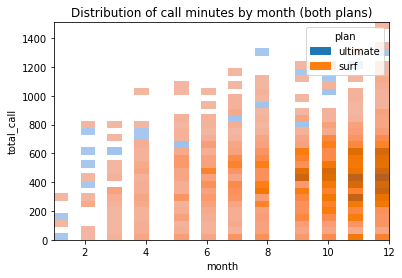

In [31]:
p = sns.histplot(data=megaline_total,x='month',y='total_call',hue='plan');
plt.title('Distribution of call minutes by month (both plans)');

What we see here is the total call minutes used by both plans per month. Not very informative

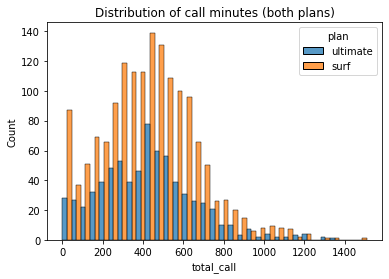

In [32]:
p1 = sns.histplot(data=megaline_total,x='total_call',hue='plan',multiple="dodge");
plt.title('Distribution of call minutes (both plans)');

Here we can see the general dist. of call minutes for both plans. as it appears the dist. is very similar and the difference in bar hight is due to the differnt no. of users for each plan

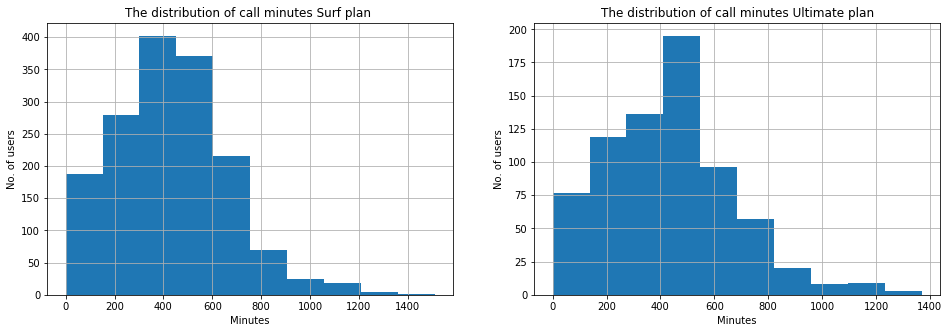

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))



axs[0].hist(x = surf_group['total_call'] )
axs[0].grid()
axs[0].set_title('The distribution of call minutes Surf plan ')
axs[0].set_xlabel('Minutes')
axs[0].set_ylabel('No. of users')

axs[1].hist(x = ultimate_group['total_call'])
axs[1].grid()
axs[1].set_title('The distribution of call minutes Ultimate plan')
axs[1].set_xlabel('Minutes')
axs[1].set_ylabel('No. of users')

plt.show()

Here we can see the dist. of call minutes for each plan seperatly. Again we can see that in both plans used between 200 and 600 minutes, and only a small number exceeded 800.

In [34]:
print('Surf calls') 
print(surf_group['total_call'].describe())
print('Surf calls variance:',surf_group['total_call'].var())
print('-'*10)
print('Ultimate calls')
print(ultimate_group['total_call'].describe())
print('Ultimate calls variance:',ultimate_group['total_call'].var())

Surf calls
count    1573.000000
mean      428.749523
std       234.453150
min         0.000000
25%       272.000000
50%       425.000000
75%       576.000000
max      1510.000000
Name: total_call, dtype: float64
Surf calls variance: 54968.27946065038
----------
Ultimate calls
count     720.000000
mean      430.450000
std       240.508762
min         0.000000
25%       260.000000
50%       424.000000
75%       565.250000
max      1369.000000
Name: total_call, dtype: float64
Ultimate calls variance: 57844.46481223922


Here we can see that both plans' call minutes mean are similar(428 for Surf, 430 for Ultimate). Also the standart diviation is similar(234 for Surf, 240 for Ultimate).Ultimate calls variance: 57844.464, Surf calls variance: 54968.279

#### Internet data

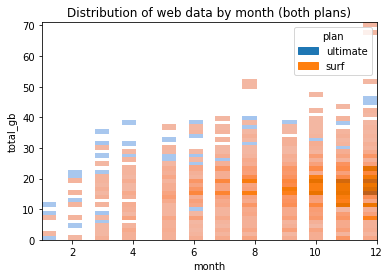

In [35]:
p2 = sns.histplot(data=megaline_total,x='month',y='total_gb',hue='plan');
plt.title('Distribution of web data by month (both plans)');

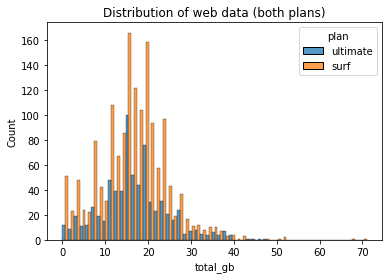

In [36]:
p3 = sns.histplot(data=megaline_total,x='total_gb',hue='plan',multiple="dodge");
plt.title('Distribution of web data (both plans)');

Again we can see that also for internet data usage the users of both plans have very similar behavior

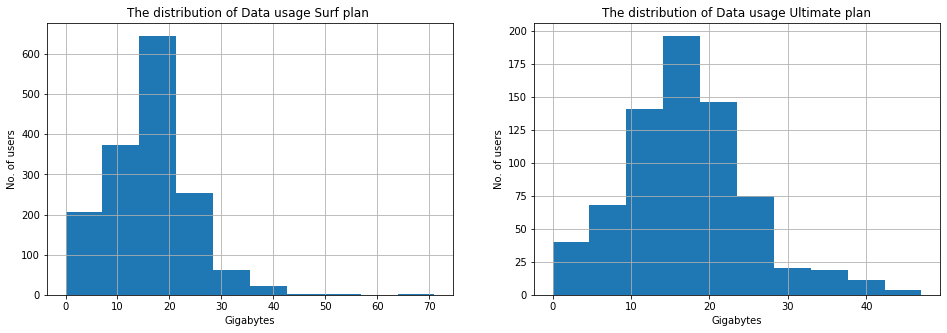

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))



axs[0].hist(x = surf_group['total_gb'] )
axs[0].grid()
axs[0].set_title('The distribution of Data usage Surf plan ')
axs[0].set_xlabel('Gigabytes')
axs[0].set_ylabel('No. of users')

axs[1].hist(x = ultimate_group['total_gb'])
axs[1].grid()
axs[1].set_title('The distribution of Data usage Ultimate plan')
axs[1].set_xlabel('Gigabytes')
axs[1].set_ylabel('No. of users')

plt.show()

Here we can see the dist. of internet data usage a little more clearly. as we see most users use beyween 10-25 gigabyte regardless of their plan. what is interesting here is the the highst usage values (50-70 giga) came from Surf users who have a smaller data packege incloded in their plan.

In [38]:
print('Surf internet data') 
print(surf_group['total_gb'].describe())
print('Surf internet data variance:',surf_group['total_gb'].var())
print('-'*10)
print('Ultimate internet data')
print(ultimate_group['total_gb'].describe())
print('Ultimate internet data variance:',ultimate_group['total_gb'].var())

Surf internet data
count    1573.000000
mean       16.566434
std         8.026448
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        71.000000
Name: total_gb, dtype: float64
Surf internet data variance: 64.42385985515756
----------
Ultimate internet data
count    720.000000
mean      17.220833
std        7.864100
min        0.000000
25%       13.000000
50%       17.000000
75%       21.000000
max       47.000000
Name: total_gb, dtype: float64
Ultimate internet data variance: 61.84407162726008


Also here we can see that both plans' web data usage mean are similar(16.5 giga for Surf, 17.2 giga for Ultimate). Also the standart diviation is similar(8 giga for Surf, 7.8 giga for Ultimate), Surf internet data variance: 64.42, Ultimate internet data variance: 61.84

#### Messages

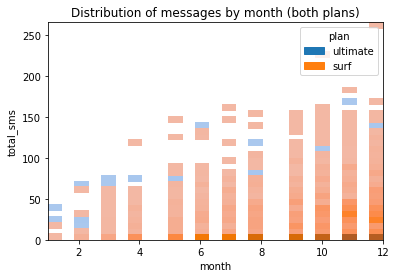

In [39]:
p4 = sns.histplot(data=megaline_total,x='month',y='total_sms',hue='plan');
plt.title('Distribution of messages by month (both plans)');

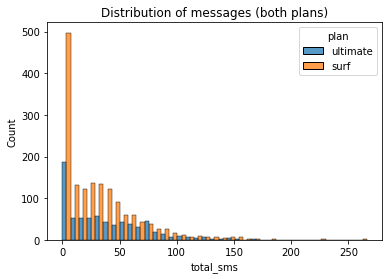

In [40]:
sns.histplot(data=megaline_total,x='total_sms',hue='plan',multiple="dodge");
plt.title('Distribution of messages (both plans)');

As for the other parameters the dist. of sms is similar for both plans

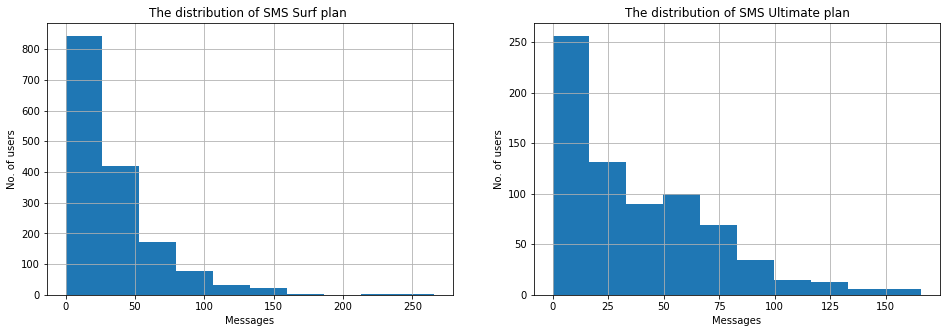

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))



axs[0].hist(x = surf_group['total_sms'] )
axs[0].grid()
axs[0].set_title('The distribution of SMS Surf plan ')
axs[0].set_xlabel('Messages')
axs[0].set_ylabel('No. of users')

axs[1].hist(x = ultimate_group['total_sms'])
axs[1].grid()
axs[1].set_title('The distribution of SMS Ultimate plan')
axs[1].set_xlabel('Messages')
axs[1].set_ylabel('No. of users')

plt.show()

Here we can see that for both plans most users send between 0-50 messages(thanks Whatsapp ;). Again the highest values come from Surf users.

In [42]:
print('Surf Messages') 
print(surf_group['total_sms'].describe())
print('Surf Messages variance:',surf_group['total_sms'].var())
print('-'*10)
print('Ultimate Messages')
print(ultimate_group['total_sms'].describe())
print('Ultimate Messages variance:',ultimate_group['total_sms'].var())

Surf Messages
count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: total_sms, dtype: float64
Surf Messages variance: 1126.7245219504068
----------
Ultimate Messages
count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: total_sms, dtype: float64
Ultimate Messages variance: 1208.7567435481378


Here we see the mean value for messages 31 for Surf and 37 for Ultimate, and the standart diviation 33.5 for Surf and 34.7 for Ultimate, Ultimate Messages variance: 1208.75, Surf Messages variance: 1126.72

#### Monthly revenue

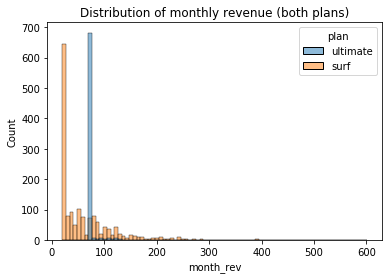

In [43]:
sns.histplot(data=megaline_total,x='month_rev',hue='plan');
plt.title('Distribution of monthly revenue (both plans)');

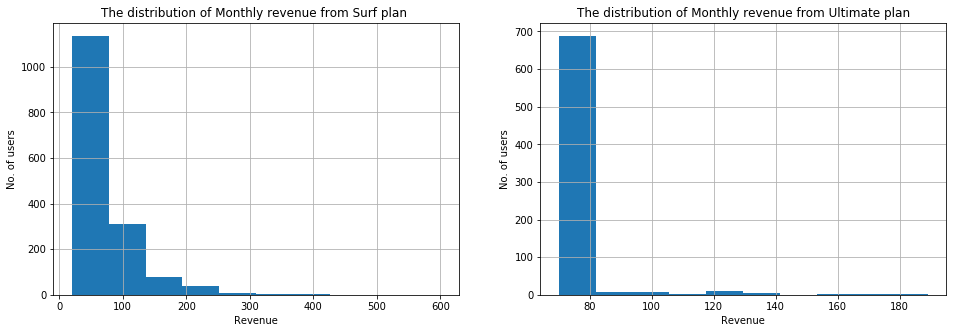

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))



axs[0].hist(x = surf_group['month_rev'] )
axs[0].grid()
axs[0].set_title('The distribution of Monthly revenue from Surf plan ')
axs[0].set_xlabel('Revenue')
axs[0].set_ylabel('No. of users')

axs[1].hist(x = ultimate_group['month_rev'])
axs[1].grid()
axs[1].set_title('The distribution of Monthly revenue from Ultimate plan')
axs[1].set_xlabel('Revenue')
axs[1].set_ylabel('No. of users')

plt.show()

Here we the dist. of monthly revenue for each plan. what is clear is that only a small no. of Ultimate users exceed their fixed monthly rate, whereas more than half of Surf exceed theirs.

In [45]:
print('Surf Monthly Rev.') 
print(surf_group['month_rev'].describe())
print('Surf Monthly Rev. variance:',surf_group['month_rev'].var())
print('-'*10)
print('Ultimate Monthly Rev.')
print(ultimate_group['month_rev'].describe())
print('Ultimate Monthly Rev. variance:',ultimate_group['month_rev'].var())

Surf Monthly Rev.
count    1579.000000
mean       60.513730
std        56.251374
min        20.000000
25%        20.000000
50%        40.000000
75%        80.315000
max       600.370000
Name: month_rev, dtype: float64
Surf Monthly Rev. variance: 3164.217033161641
----------
Ultimate Monthly Rev.
count    724.000000
mean      72.465470
std       12.018205
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      189.000000
Name: month_rev, dtype: float64
Ultimate Monthly Rev. variance: 144.43725690225654


Here we can see the mean mothly charge for Surf 60 and for Ultimate 72 and the std for Surf 56 and for Ultimate 12.Surf Monthly Rev. variance: 3164.21, Ultimate Monthly Rev. variance: 144.43  

The large difference in the variance and std's suggests that a lot of Surf users exceed their monthly plan and very few Ultimate users do the same

# Step 4: Test the hypotheses

we are going to find out if:

The average revenue from users of Ultimate and Surf calling plans differs.

The average revenue from users in NY-NJ area is different from that of the users from other regions.

### First hypotheses

H0: The average revenue from both plans is the same. (h0 allways assumes equality)

H1: The average revenue from both plans is NOT the same. (h1 can only reject h0, and not prove the opposite)

In [46]:
sample_1 = ultimate_group['month_rev']

sample_2 = surf_group['month_rev']



alpha = 0.05  # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(sample_1, sample_2, equal_var = False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  1.4407858225808047e-15
We reject the null hypothesis


According to this test the differnce in the plans' revenue mean is significant, meaning the average monthly revenue from each plan is different, with 95% certinty

I chose equal_var = False, because these two populations (the two plans) appeal to very different people and I see no reason for them to have the same variance

### Second hypotheses

H0: The average revenue from NY-NJ area is the same as all regions. (h0 allways assumes equality)

H1: The average revenue from NY-NJ area is NOT the same as all regions. (h1 can only reject h0, and not prove the opposite)

In [47]:
ny_nj = megaline_total[megaline_total['city'].str.contains('NY-NJ')]
other = megaline_total[~megaline_total['city'].str.contains('NY-NJ')]

In [48]:
sample_1 = ny_nj['month_rev']

sample_2 = other['month_rev']



alpha = 0.05  # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(sample_1, sample_2,equal_var = True)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  0.05454436789855989
We can't reject the null hypothesis


According to this test the differnce in the average revenue from NY-NJ area is NOT significant, meaning the average monthly revenue from NY-NJ area is equal to average monthly from other regions, with 95% certinty. 

I chose equal_var = True, because these two populations (NY NJ area and other regions) should have the same differences within them. there are all kinds of people living in every region.

# Conclusions

#### Data preprocessing

- The data recieved was devided into 4 tables, First we check the dates for our data and create a month column for each data set.

- Then we create one table with all of the web, call and sms data summed up for each month and grouped by user.

- The data had no null's or duplicates

#### EDA

- Our client base has grown with each month in the year 2018, this means that analyzing and comparing the data month to month will not be usefull since we have more clients every month and their usage of calls SMS and internet data rises constantly as well as Megaline's revenue. 

- We see [here](#Step-3.-Analyze-the-data) that despite what is written in the previous article usage of calls SMS and internet data has risen in a fairely constant way all through 2018, and that usage for both plans is similar. we have in our data about twice as much Surf plan users(339) than Ultimate(161) and the usage of calls SMS and internet data for Surf per month is almost double that of Ultimate.

- Call minutes is simillar for both plans most clients used between 200 and 600 minutes also call minutes mean are similar(428 for Surf, 430 for Ultimate).

- Internet data is simillar for both plans most users use beyween 10-25 gigabyte regardless of their plan.data usage mean are similar(16.5 giga for Surf, 17.2 giga for Ultimate), what is interesting here is the the highst usage values (50-70 giga) came from Surf users who have a smaller data packege incloded in their plan.

- Messages most users send between 0-50 messages,mean value for messages 31 for Surf and 37 for Ultimate.

- Monthly revenue the mean mothly charge for Surf is 60 dollars and for Ultimate is 72 dollars, the std for Surf 56 and for Ultimate 12. The large difference in the std's suggests that a lot of Surf users exceed their monthly plan and very few Ultimate users do the same.

#### Hypotheses testing

- The hypotheses that the average monthly revenue from the Surf and Ultimate call plans is the same was regected withe 95% certinty. 

- The hypotheses that the average monthly revenue from the NY-NJ area is the same as all other regions was NOT rejected also with 95% certinty

